# Week 8 - Conversation and Text Generation
Many natural language activities boil down to text generation, especially the back-and-forth nature of natural conversation and question answering. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

Much 2022 NLP research is on text generation. Most famously, this is the primary use of large language models like GPT-3 (OpenAI), Wu Dao (Beijing Academy of AI), and Gopher (DeepMind).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import seaborn as sns
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os
import io
import zipfile

import networkx as nx

%matplotlib inline

import torch # pip install torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
!pip install transformers
from transformers import BertTokenizer, BertConfig # pip install tranformers
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange

  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to /tmp/pip-req-build-ct2b33al
  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git /tmp/pip-req-build-ct2b33al
     |████████████████████████████████| 5.6 MB 13.0 MB/s 
     |████████████████████████████████| 117 kB 70.1 MB/s 
     |████████████████████████████████| 181 kB 85.3 MB/s 
     |████████████████████████████████| 76 kB 6.8 MB/s 
     |████████████████████████████████| 132 kB 58.0 MB/s 
     |████████████████████████████████| 32.8 MB 1.2 MB/s 
     |████████████████████████████████| 8.6 MB 62.1 MB/s 
     |████████████████████████████████| 79 kB 10.3 MB/s 
     |████████████████████████████████| 138 kB 85.2 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 5.1 MB 55.0 MB/s 
     |████████████████████████████████| 127 kB 77.0 MB/s 
  Created wheel for lucem-illud: filename=lucem_illud-8.0.1-py3

In [3]:
%matplotlib inline

In [4]:
!cd /content/drive/MyDrive/Colab\ Notebooks/week8-text-generation

In [5]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

In [208]:
placeholder = torch.Tensor([100, 100, 100]).cuda()

# ConvoKit
As we alluded to in Week 6 with causal inference, [ConvoKit](https://convokit.cornell.edu/) is an exciting platform for conversational analysis developed by Jonathan Chang, Calem Chiam, and others, mostly at Cornell. Keep this in mind if you are interested in a final project with conversational data such as Twitter threads or movie scripts. They have an [interactive tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), which we include some examples from below. Most of the following text and code is authored by them.

These ConvoKit corpora can be used for the next exercise in this notebook.

In [7]:
try:
    import convokit
except ModuleNotFoundError:
    !pip install convokit

     |████████████████████████████████| 167 kB 14.1 MB/s 
     |████████████████████████████████| 6.0 MB 76.3 MB/s 
     |████████████████████████████████| 1.5 MB 80.3 MB/s 
     |████████████████████████████████| 235 kB 94.6 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 175 kB 103.9 MB/s 
     |████████████████████████████████| 749 kB 59.4 MB/s 
     |████████████████████████████████| 181 kB 60.7 MB/s 
     |████████████████████████████████| 628 kB 53.1 MB/s 
     |████████████████████████████████| 10.1 MB 63.8 MB/s 
     |████████████████████████████████| 451 kB 57.0 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
  Created wheel for convokit: filename=convokit-2.5.3-py3-none-any.whl size=204129 sha256=0b32666330813fdc830ce471eccb9bbf6304432527c5882e5c59a9294cea947a
  Stored in directory: /root/.cache/pip/wheels/b0/e8/2d/81c4477fe586fe4dad2de2886b990e90e839ffccd5158ed0f3
  Created wheel for emoji: filename=emoji-1.

In [8]:
# for pretty printing of cells within the Colab version of this notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [9]:
import convokit
from convokit import Corpus, download

### Loading a Corpus

A Corpus represents a conversational dataset. We typically begin our analysis by loading a Corpus. A list of existing datasets already in ConvoKit format can be found [here](https://convokit.cornell.edu/documentation/datasets.html). 

A growing list of many other conversational datasets covering a variety of conversational settings are available in ConvoKit, such as face-to-face (e.g. the [*Intelligence Squared Debates corpus*](https://convokit.cornell.edu/documentation/iq2.html)), institutional (e.g. the [*Supreme Court Oral Arguments corpus*](https://convokit.cornell.edu/documentation/supreme.html)), fictional (e.g. the [*Cornell Movie Dialog Corpus*](https://convokit.cornell.edu/documentation/movie.html)), or online  (e.g. all talkpage conversations on [*Wikipedia Talk Pages*](https://convokit.cornell.edu/documentation/wiki.html) and a full dump of [*Reddit*](https://convokit.cornell.edu/documentation/subreddit.html)).

For this tutorial, we will primarily be using the *r/Cornell* subreddit corpus to demo various ConvoKit functionality, and occasionally the [*Switchboard Dialog Act Corpus*](https://convokit.cornell.edu/documentation/switchboard.html) (a collection of anonymized five-minute telephone conversations) as a contrasting dataset.

In [11]:
corpus = Corpus(download('subreddit-Cornell'))

# You can try a different corpus if you want.
#corpus = Corpus(download('diplomacy-corpus'))
#corpus = Corpus(download('switchboard-corpus'))
#corpus = Corpus(download('reddit-corpus-small'))

In [12]:
corpus.print_summary_stats()

Number of Speakers: 7568
Number of Utterances: 74467
Number of Conversations: 10744


### Corpus components: Conversations, Utterances, Speakers

Every Corpus has three main components: [Conversations](https://convokit.cornell.edu/documentation/conversation.html), [Utterances](https://convokit.cornell.edu/documentation/utterance.html), and [Speakers](https://convokit.cornell.edu/documentation/speaker.html). Just as in real life, in ConvoKit, Conversations are some sequence of Utterances, where each Utterance is made by some Speaker. Let's look at an example of each.

In [13]:
# This is a Reddit thread
corpus.random_conversation().meta

{'author_flair_text': '',
 'domain': 'self.Cornell',
 'gilded': 0,
 'gildings': None,
 'num_comments': 8,
 'stickied': False,
 'subreddit': 'Cornell',
 'timestamp': 1513380810,
 'title': 'To Everyone On this Subreddit'}

In [14]:
# This is a Reddit post or comment.
corpus.random_utterance().meta

{'author_flair_text': '',
 'gilded': 0,
 'gildings': None,
 'permalink': '',
 'retrieved_on': 1427611944,
 'score': 1,
 'stickied': False,
 'subreddit': 'Cornell',
 'top_level_comment': 'c2kjwyg'}

In [16]:
# The r/Cornell Corpus does not have speaker metadata.
corpus.random_speaker().meta

#Speaker do have an 'id' which is their Reddit username, as seen here.
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7f81e31c4dd0>, 'id': 'lolol2345'})

In [17]:
# We can iterate through these objects as we iterate lists or DataFrames in Python.
for utt in corpus.iter_utterances():
    print(utt.text)
    break 

I was just reading about the Princeton Mic-Check and it's getting [national press](http://www.bloomberg.com/news/2011-12-29/princeton-brews-trouble-for-us-1-percenters-commentary-by-michael-lewis.html).

I want to get a sense of what people felt like around campus. Anything interesting happen? Anything interesting coming up?


Conversations, Utterances, and Speakers are each interesting, but the magic of conversational analysis is connecting them. For example, we can get all the Conversations in which a Speaker has participated and all the Utterances they have made. To make it more interesting, we can find a Speaker to study by navigating from a random Utterance.

In [18]:
# consider this sequence of operations that highlight how to navigate between components
utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
spkr_convos[:3]

[Conversation({'obj_type': 'conversation', 'meta': {'title': 'to my secret admirer', 'num_comments': 5, 'domain': 'self.Cornell', 'timestamp': 1534118248, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f81e31c4dd0>, 'id': '96tkvd'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'Guys just keep in mind', 'num_comments': 17, 'domain': 'self.Cornell', 'timestamp': 1534589965, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f81e31c4dd0>, 'id': '98aw1n'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'rain during class photo... that’s 2/2 :D', 'num_comments': 7, 'domain': 'self.Cornell', 'timestamp': 1534972742, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flai

For a more qualitative feel of the data, you can display a Conversation. For Reddit data, this is a single thread.

In [19]:
# We truncate sentences at character 80 to avoid making this notebook too long!
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")

Title^. I’m trying to fight off the dreaded freshman 15, and was wondering if th

    There's one in the men's locker rooms at Teagle and Helen Newman. I'm guessing t

        Can confirm that they also have them in the women's locker rooms. 

    I feel this post in my soul

    [deleted]

    I just ended up buying on for everyday use 

    There is one on the first floor of the Cornell store if you are willing to publi



There is a lot more to ConvoKit that we encourage you to explore, especially their [tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), but the ability to seamlessly navigate between the Utterances, Conversations, and Speakers of a Corpus is extremely valuable for social science.

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that use ConvoKit to analyze a Corpus other than 'subreddit-Cornell', including at least one function you find in the package not used above. You can also generate a ConvoKit Corpus from your own dataset based on [their Corpus from .txt files tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/converting_movie_corpus.ipynb) or [their Corpus from pandas tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/corpus_from_pandas.ipynb), but that may be time-consuming for a weekly assignment. (It could be a great idea for your final project!)

In [20]:
corpus2 = Corpus(download('diplomacy-corpus'))
corpus2.print_summary_stats()

Number of Speakers: 83
Number of Utterances: 17289
Number of Conversations: 246


In [23]:
corpus2.random_conversation().meta

{'acl2020_fold': 'Train'}

In [24]:
corpus2.random_utterance().meta

{'absolute_message_index': 2219,
 'deception_quadrant': 'Caught',
 'game_score': '10',
 'game_score_delta': '3',
 'receiver': 'germany-Game1',
 'receiver_perception': 'Lie',
 'relative_message_index': 287,
 'speaker_intention': 'Lie',
 'year': '1907'}

In [25]:
corpus2.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {'country': 'austria'}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7f81d671b310>, 'id': 'austria-Game6'})

In [26]:
for utt in corpus2.iter_utterances():
    print(utt.text)
    break 

Germany!

Just the person I want to speak with. I have a somewhat crazy idea that I’ve always wanted to try with I/G, but I’ve never actually convinced the other guy to try it. And, what’s worse, it might make you suspicious of me. 

So...do I suggest it?

I’m thinking that this is a low stakes game, not a tournament or anything, and an interesting and unusual move set might make it more fun? That’s my hope anyway.

What is your appetite like for unusual and crazy?


In [37]:
utt = corpus2.random_utterance()
utt.meta

{'absolute_message_index': 1847,
 'deception_quadrant': 'Straightforward',
 'game_score': 0,
 'game_score_delta': '-11',
 'receiver': 'italy-Game3',
 'receiver_perception': 'Truth',
 'relative_message_index': 141,
 'speaker_intention': 'Truth',
 'year': '1909'}

In [34]:
utt = corpus2.random_utterance()
convo = utt.get_conversation()
spkr = utt.speaker
spkr_convos = list(spkr.iter_conversations())
spkr_convos[:3]

[Conversation({'obj_type': 'conversation', 'meta': {'acl2020_fold': 'Train'}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f81d671b310>, 'id': 'Game9-england-italy'}),
 Conversation({'obj_type': 'conversation', 'meta': {'acl2020_fold': 'Train'}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f81d671b310>, 'id': 'Game9-england-germany'}),
 Conversation({'obj_type': 'conversation', 'meta': {'acl2020_fold': 'Train'}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x7f81d671b310>, 'id': 'Game9-england-austria'})]

In [36]:
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")

Hey Russia, looking forward to a great game 🙃. I think we should discuss Scandin

    Always good to discuss things in advance to avoid unnecessary nonsense. I'm not 

        Sounds good

            That was a hell of a bluff you must have pulled to put that army in the Netherla

                Thanks 😊.

                    So I'm guessing you plan on hitting the Germans then? Need help with that?

                        Well... I suppose I could let you have/help with Berlin, but don’t build any fle

                            That's asking a whole lot considering how the Britain/Russia paradigm often ends

                                I would like to focus all my attention on Germany, which could leave me a bit ex

                                    I definitely understand that, and I trust you, but it's better to trust and *als

                                        Verify... how?

                                            By making it harder for you to simply walk int

In [38]:
from convokit import FightingWords
fw = FightingWords()
fw.fit(corpus2, class1_func = lambda utt: utt.meta['speaker_intention'] == 'Truth',
       class2_func = lambda utt: utt.meta['speaker_intention'] == 'Lie')

Initializing default CountVectorizer with ngram_range (1, 3)... Done.
class1_func returned 16402 valid corpus components. class2_func returned 887 valid corpus components.
Vocab size is 7772
Comparing language...
ngram zscores computed.


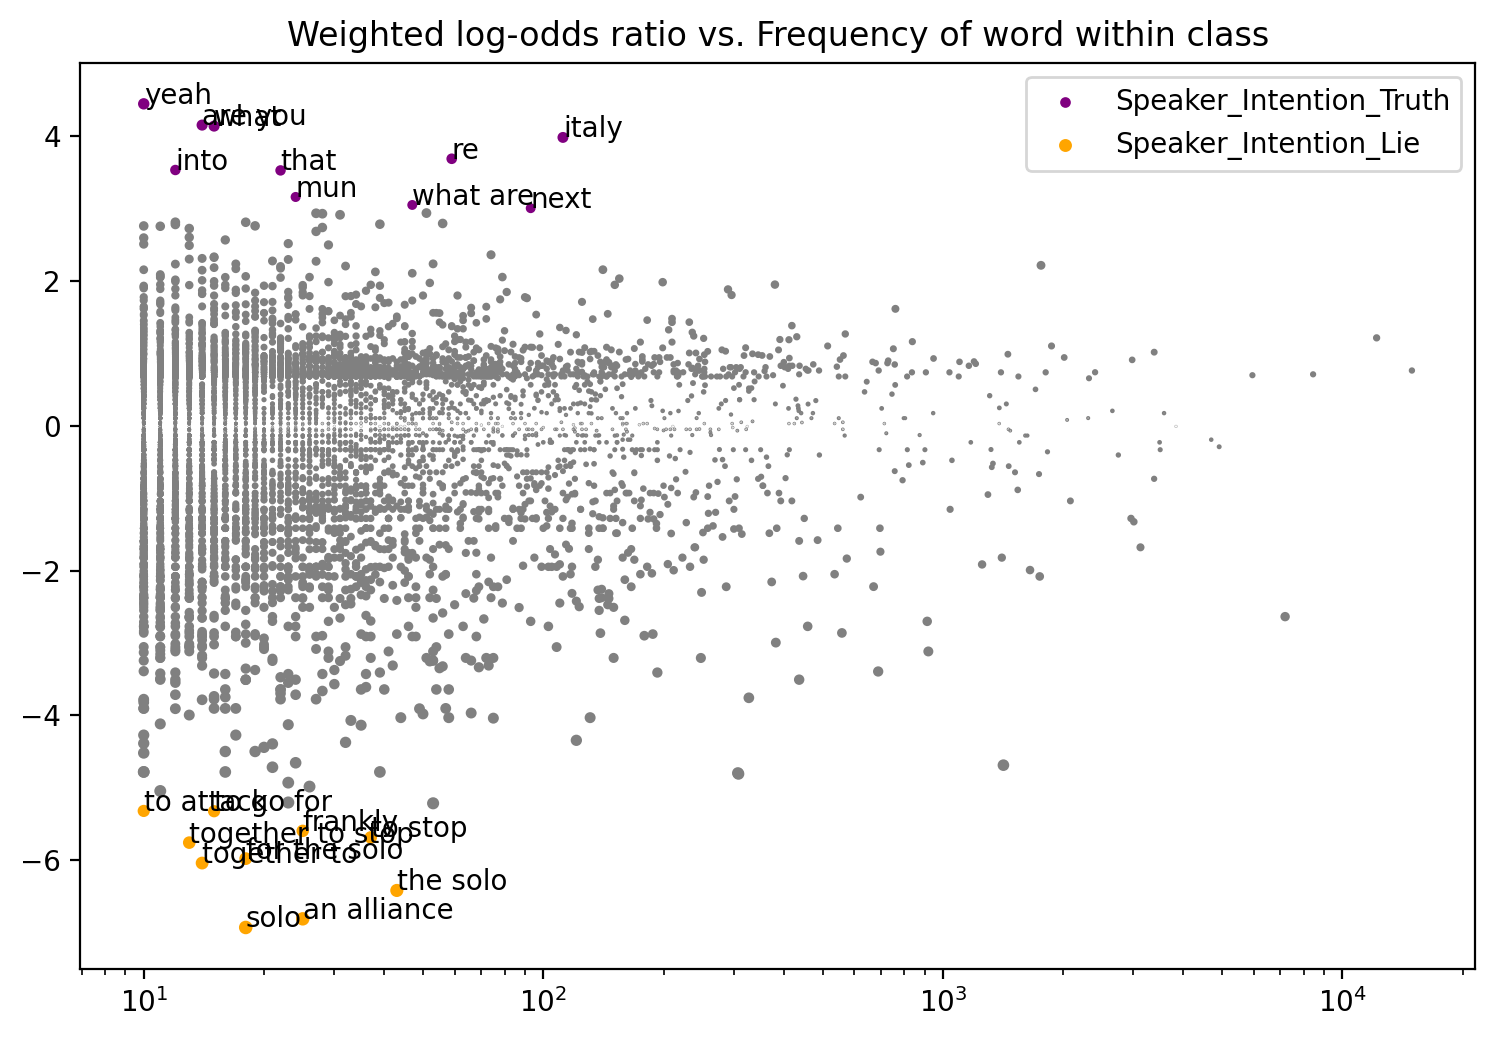

,z-score,class
ngram,,
solo,-6.932077,Speaker_Intention_Lie
an alliance,-6.812717,Speaker_Intention_Lie
the solo,-6.420356,Speaker_Intention_Lie
together to,-6.041758,Speaker_Intention_Lie
for the solo,-5.980728,Speaker_Intention_Lie
...,...,...
re,3.692112,Speaker_Intention_Truth
italy,3.987058,Speaker_Intention_Truth
what,4.143625,Speaker_Intention_Truth


In [39]:
fw.summarize(corpus2, plot=True, class1_name='Speaker_Intention_Truth', class2_name='Speaker_Intention_Lie')

Interesting. When players say some pretty words like 'alliance', it's possible  that they're intend to cheat. But when they decide to tell some truths, the wording is more verbal.  

## Creating networks of agents from corpora

Now let's return to the Davies corpora (specifically, Soap Operas) to see how we can extract actors and build a network of their relationships in the texts.

We'll use the `lucem_illud.loadDavies()` function to get the dataframe. Make sure to download `SOAP.zip` from DropBox, unzip, and edit the following line with the path to that file. This code may take some time.

In [10]:
corpora_address = "/content/drive/MyDrive/Colab Notebooks/week8-text-generation/SOAP"

In [11]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text_0-tez.zip
text_1-teh.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_5-rag.zip
text_6-egn.zip
text_7-jss.zip
text_8-sbo.zip
text_9-jtw.zip


We now use the source to see how the data is stored. Note that this is different from the movies corpus, and that we will need to use a different aggregating method to store the data. Each dataset would have a different approach, but they are all very similar, it depends on how the data is stored. Here multiple textids match multiple scripts, so our soap dataframe would be structured a little differently. 

You can see the first 20 lines of the source file here.

In [12]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [13]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [14]:
source[0:20]

[b'textID\tyear\tshow\t\turl\r\n',
 b'-----\t-----\t-----\t\t-----\r\n',
 b'\r\n',
 b'1\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-04-09-01.shtml\r\n',
 b'2\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-05-09-01.shtml\r\n',
 b'3\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-06-20-01.shtml\r\n',
 b'4\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-07-01.shtml\r\n',
 b'5\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-08-01.shtml\r\n',
 b'6\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-09-01.shtml\r\n',
 b'7\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-10-01.shtml\r\n',
 b'8\t2001\tAll My Childen\thttp://tvmegasite.net/transcripts/amc/older/2001/amc-trans-08-13-01.shtml\r\n',
 b'9\t2001\tAll My Childen\thttp://tvmegasite.net/tra

In [15]:
soap_dict = {}

In [16]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [17]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [18]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [19]:
i = 0

In [20]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [21]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Liza, You, 're, in, early, @!Ryan, Yeah, I,..."
1,As the World Turns,"[@!Katie, Simon, where, are, you, @!Simon, Kat..."
2,Bold and Beautiful,"[@!Morgan, What, 's, the, matter, Stephanie, Y..."
3,Days of Our Lives,"[@!Philip, Seems, like, every, time, I, look, ..."
4,General Hospital,"[@!Stefan, I, love, her, @!Jax, No, Cassadine,..."
5,Guiding Light,"[@!Reva, Well, it, 's, very, peaceful, Your, b..."
6,One Life to Live,"[@!Rae, What, She, even, has, a, new, friend, ..."
7,Passions,"[@!Kay, Going, to, get, pregnant, and, I, 'm, ..."
8,Port Charles,"[@!Jack, There, you, are, you, son, @!Chris, H..."
9,Young and Restless,"[@!Sharon, Yeah, I, could, n't, sleep, @!Victo..."


We now have each Soap, and each of the Tokenized texts. Let us see what kind of information we can get. These are American soap operas, and are likely to be cheesy and dramatic (an understatment). A fun start would be to make networks of each of the actors and actresses in these soaps. 

What would be a good way to create a network? Maybe everytime someone talks to someone we add one weight? But we wouldn't want to add weights whenever it's a different scene - or maybe we do? Let us look at the text and figure it out.

Note that we didn't add the year here because it spans over multiple years. If we are doing different kinds of analysis we would want to a years column as well.

In my dataframe, Days of Our Lives is the 4th corpora, and I conducted my basic analysis on that.

In [22]:
dool = soap_df['Tokenized Texts'][3]

In [23]:
' '.join(dool[0:1500])

"@!Philip Seems like every time I look at you tonight you 're crying @!Chloe Tears of happiness I always thought that when I read Tears of Happiness what a crock But tonight you prove to me that they really do exist @!Philip I just carved our initials on that tree @!Chloe But it was so much more than that You took this angry outsider and you made her feel like a girl in a movie or a book a happy movie or a book @!Philip That 's what you deserve to be What gets me is that you do n't even realize how special you are @!Chloe All my life the word special was code for too weird for words And now here you are this great looking guy with a normal life and you make me believe like you really actually want me around @!Philip Oh that 's only half true @!Chloe Oh I 'm sorry @!Philip Oh no Chloe I want you around forever That 's so true but 's not true at all Except for you there 's nothing normal at all about my life @!Brenda We got to get the labs back on 23 @!Woman I 'll grab them @!Brenda Okay

Hmmm... we can't do our normal text processing. But this provides us with an interesting oppurtunity: every '@!' is followed by some useeful information. Let us do a quick check of how many characters exist here, and how many times they speak.

In [24]:
characters = {}

In [25]:
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1


In [26]:
len(characters)

878

In [27]:
characters

{'': 46,
 '&gt;&amp;gtBe': 1,
 '&gt;&gt;Hahawn': 2,
 '&gt;&gt;Wn': 1,
 "'ll": 2,
 "'m": 11,
 "'t": 99,
 '**25;0;TOOLONG': 1,
 '**25;2251;TOOLONG': 1,
 '**25;2278;TOOLONG': 1,
 '**25;275;TOOLONG': 1,
 '**25;27;TOOLONG': 1,
 '**25;63;TOOLONG': 1,
 '**25;92;TOOLONG': 1,
 '**26;114;TOOLONG': 1,
 '**26;116;TOOLONG': 1,
 '**26;219;TOOLONG': 1,
 '**26;222;TOOLONG': 1,
 '**26;619;TOOLONG': 1,
 '**26;64;TOOLONG': 1,
 '**27;0;TOOLONG': 1,
 '**27;634;TOOLONG': 1,
 '**27;663;TOOLONG': 1,
 '**27;832;TOOLONG': 1,
 '**28;235;TOOLONG': 1,
 '.A': 21,
 '.J': 1,
 'Abby': 453,
 'Abe': 1117,
 'Abigail': 218,
 'Accelerated': 1,
 'Adams': 11,
 'Adrienne': 264,
 'Agent': 1,
 'Aggravated': 1,
 'Al': 9,
 'Alarm': 2,
 'Alex': 215,
 'Alice': 137,
 'All': 42,
 'Allie': 15,
 'Aloud': 3,
 'Ami': 2,
 'Anderson': 2,
 'Andr': 57,
 'Andrew': 11,
 'Angelo': 12,
 'Anna': 190,
 'Anne': 6,
 'Announcer': 5,
 'Applause': 4,
 'Approaching': 1,
 'Arianna': 563,
 'Arnie': 8,
 'Art': 13,
 'Artemis': 3,
 'Asassie': 1,
 'Attendant'

Wow, that's a lot of characters: but we notice a '@!' between certain actions too, such as screaming and sobbing. Let us maybe only look for characters with a high number of appearances?

In [28]:
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

Philip 2846
Bo 4179
Shawn 2507
Hope 3793
Belle 2518
John 2542
Brady 2265
Marlena 2458
Nicole 2892
Kate 2503
Sami 5462
Lucas 2546


Let's check these folks out on the interwebz...a image of search of the name + "days of our lives":

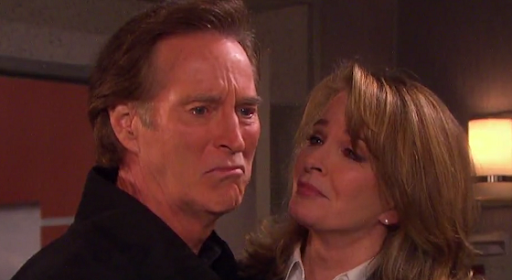

In [29]:
Image(filename='/content/drive/MyDrive/Colab Notebooks/data/data/dool/dool_john.png') 

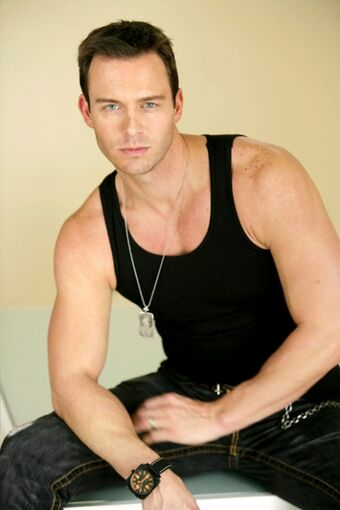

In [30]:
Image(filename='/content/drive/MyDrive/Colab Notebooks/data/data/dool/dool_brady.jpg') 

In [ ]:
# Image(filename='../data/dool/dool_hope.jpeg')

In [ ]:
# Image(filename='../data/dool/dool_philip.jpeg')

In [ ]:
# Image(filename='../data/dool/dool_marlena.jpg')

In [ ]:
# Image(filename='../data/dool/dool_kate.png')

In [ ]:
# Image(filename='../data/dool/dool_bo.png')

In [ ]:
# Image(filename='../data/dool/dool_chloe.jpg')

In [ ]:
# Image(filename='../data/dool/dool_sami.jpg')

In [ ]:
# Image(filename='../data/dool/dool_shawn.jpg')

In [ ]:
# Image(filename='../data/dool/dool_belle.jpg')

In [ ]:
# Image(filename='../data/dool/dool_lucas.jpg')

In [ ]:
# Image(filename='../data/dool/dool_nicole.jpg')

These are definitely big, long-time players in the dramatic Days narrative. It would make sense to create a graph where each character who appears over 2000 times is a node, and each time they talk to each other, we add one to their weight. We should also store all the things these chracters say: that's useful information.

So we now iterate through the tokens in a manner where we can capture this information.

In [31]:
actor_network = nx.Graph()

In [32]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [33]:
len(actor_network.nodes.data())

12

In [34]:
actor_network.nodes.data()

NodeDataView({'Philip': {'lines_spoken': 2846, 'words': []}, 'Bo': {'lines_spoken': 4179, 'words': []}, 'Shawn': {'lines_spoken': 2507, 'words': []}, 'Hope': {'lines_spoken': 3793, 'words': []}, 'Belle': {'lines_spoken': 2518, 'words': []}, 'John': {'lines_spoken': 2542, 'words': []}, 'Brady': {'lines_spoken': 2265, 'words': []}, 'Marlena': {'lines_spoken': 2458, 'words': []}, 'Nicole': {'lines_spoken': 2892, 'words': []}, 'Kate': {'lines_spoken': 2503, 'words': []}, 'Sami': {'lines_spoken': 5462, 'words': []}, 'Lucas': {'lines_spoken': 2546, 'words': []}})

In [35]:
actor_network.nodes.data()

NodeDataView({'Philip': {'lines_spoken': 2846, 'words': []}, 'Bo': {'lines_spoken': 4179, 'words': []}, 'Shawn': {'lines_spoken': 2507, 'words': []}, 'Hope': {'lines_spoken': 3793, 'words': []}, 'Belle': {'lines_spoken': 2518, 'words': []}, 'John': {'lines_spoken': 2542, 'words': []}, 'Brady': {'lines_spoken': 2265, 'words': []}, 'Marlena': {'lines_spoken': 2458, 'words': []}, 'Nicole': {'lines_spoken': 2892, 'words': []}, 'Kate': {'lines_spoken': 2503, 'words': []}, 'Sami': {'lines_spoken': 5462, 'words': []}, 'Lucas': {'lines_spoken': 2546, 'words': []}})

In [36]:
actor_network.nodes['Sami']['lines_spoken']

5462

In [37]:
i = 0

The following lines of code creates the graph of actors and their relationships.

In [38]:
# 逻辑是A：说话。B：说话。认为A说的话是对B说的
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

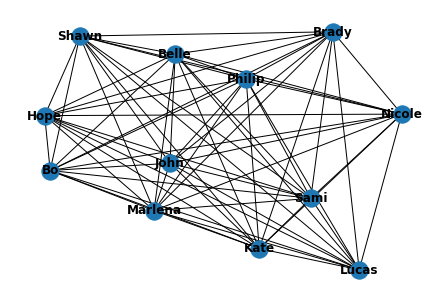

In [39]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

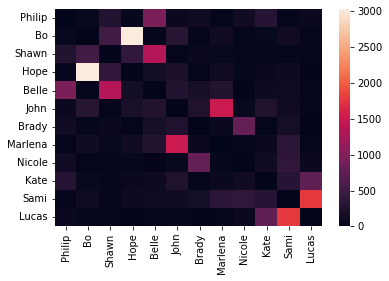

In [40]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [41]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(actor_network))

In [42]:
c

[frozenset({'Belle',
            'Bo',
            'Brady',
            'Hope',
            'John',
            'Kate',
            'Lucas',
            'Marlena',
            'Nicole',
            'Philip',
            'Sami',
            'Shawn'})]

### Finding structure in networks

We now have a lot of useful information: we have a graph of all the characters, with their relationships with other characters, as well as all the words they've said. We tried finding communities, but it seems like everyone is connected to everyone: each of them form their own 'community'. Seems like people talk to each other a bunch in soaps.

This is however, not the best network to find any meaningful patterns, as we can see with everyone connected to everyone. But as we can see with our heatmap, not everyone talks to everyone an equal amount. How about we only keep our "important" ties, where people are talking to each other a lot?

In [43]:
smaller_actor_network = nx.Graph()

In [44]:
for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 250:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])


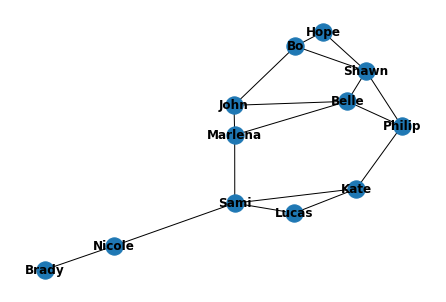

In [45]:
nx.draw(smaller_actor_network, with_labels=True, font_weight='bold')

This is a lot more interesting: while the sets of characters overlap, there is still two distinct communities if you look at characters who regularly talk to each other!

Let us see what our centrality measures look like, as well as communities.

In [46]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(smaller_actor_network))

In [47]:
c

[frozenset({'Kate', 'Lucas', 'Philip', 'Sami'}),
 frozenset({'Bo', 'Hope', 'Shawn'}),
 frozenset({'Belle', 'John', 'Marlena'}),
 frozenset({'Brady', 'Nicole'})]

In [48]:
dcentralities = nx.degree_centrality(smaller_actor_network)

In [49]:
dcentralities['John'], dcentralities['Philip']

(0.2727272727272727, 0.2727272727272727)

Our two different communities show up as detected by the networkx algorithm, and when we look at centralities, we can see that John is a lot more central than Philip.

说反了


Let us go back to our original graph, and see if the weight or number of similar appearences matches the text... how do we do this? Well, we already have the graph, and we also have information of who spoke to who. So we have our framework!

This means we can explore ideas contained in two of the papers you will be reading: . “No country for old members: User lifecycle and linguistic change in online communities.”, and  “Fitting In or Standing Out? The Tradeoffs of Structural and Cultural Embeddedness”, both of which you can access on Canvas. 

Let us use a simplified version of the papers, and check if a higher number of conversations might lead to a higher similarity between the word distributions for two characters. We can use the same divergences we used in the last notebook. Do you think it will match with the number of times each character was associated with each other?

In [50]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [51]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud.normalizeTokens(character_words))

In [52]:
L = []

In [53]:
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

In [56]:
len(M)

12

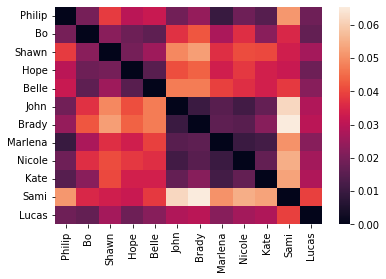

In [54]:
fig = plt.figure()
div = pd.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [55]:
np.corrcoef(M_, M)[0]
# M_is the weight list

array([ 1.        , -0.15659229,  0.77781138, -0.10048207, -0.12663172,
       -0.08122789,  0.0452386 ,  0.00113666, -0.18821411, -0.24789866,
       -0.11526811, -0.11290618,  0.26402906, -0.18822315, -0.21197682,
       -0.23750693, -0.60548622,  0.29225934,  0.24329836,  0.33789832,
        0.18169751,  0.1279459 , -0.00993151,  0.05373638])

With our two heatplots, we can attempt to do some rudimentary analysis. We can see from our previous plot that Shawn and Belle talk to each other a lot, so do Hope and Bo, and Nicole and Brady, and Lucas and Sami. Do they also talk *like* each other?

Kind of, actually: all four of these pairs have a lower distance between them. Now I don't know anything about this particular soap... are these four pairs related? Are they in a relationship, either married or dating, or are they just really good friends?

This lays out the frameworks which you can now use to explore your own networks. 

# Interactional influence

Before we utilize transformers, let's see how to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network based on a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf). This relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [57]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [58]:
result_path = '/content/drive/MyDrive/Colab Notebooks/data/data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [59]:
df_meta_info = pd.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pd.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pd.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pd.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pd.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Foreman': 3,
 'Juror 10': 2,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 2': 9,
 'Juror 3': 1,
 'Juror 4': 5,
 'Juror 5': 11,
 'Juror 6': 8,
 'Juror 7': 4,
 'Juror 8': 0,
 'Juror 9': 10}

In [60]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

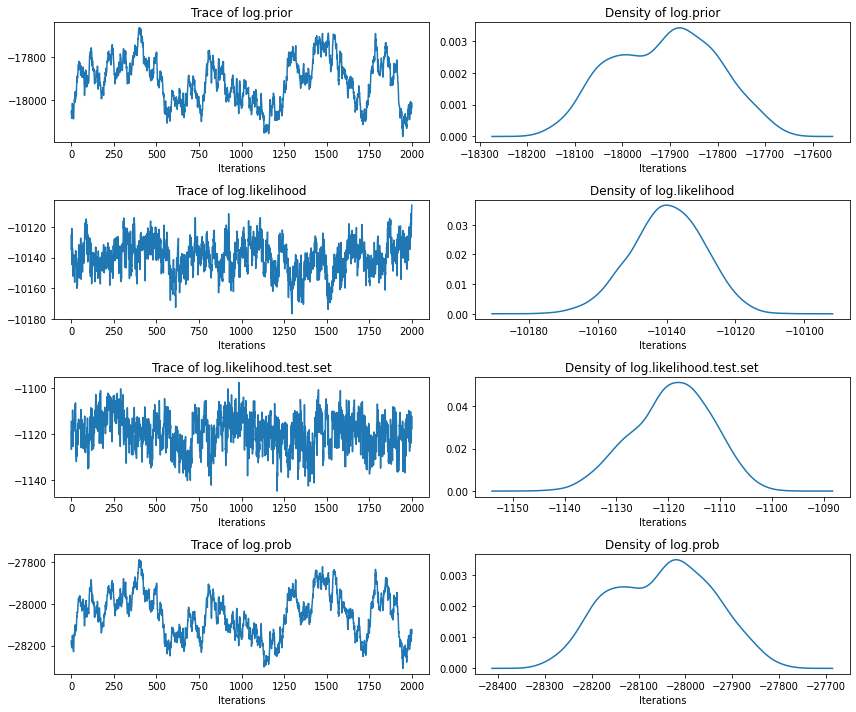

In [61]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [62]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [63]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pd.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [64]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [65]:
df_mean

,Juror 8,Juror 3,Juror 10,Foreman,Juror 7,Juror 4,Juror 11,Juror 12,Juror 6,Juror 2,Juror 9,Juror 5
Juror 8,0.000000,3.757957,8.089079,0.930180,5.167497,0.794645,0.845335,1.336329,6.106684,0.916765,6.385205,7.300776
Juror 3,8.529312,0.000000,6.673916,4.150076,2.534751,4.902852,1.092571,0.509942,3.825015,3.861767,0.266426,1.561626
Juror 10,8.413188,7.427932,0.000000,4.540236,3.216307,1.030049,1.004598,0.529232,2.426582,0.407460,1.233599,0.885871
Foreman,1.137060,0.612615,1.945196,0.000000,1.521390,0.834870,1.338554,3.230634,1.013511,3.534036,1.311436,4.115411
Juror 7,2.603853,5.901169,0.648844,1.969868,0.000000,1.110101,0.279870,0.608548,1.047693,2.910670,1.619475,1.570038
Juror 4,5.791320,0.200669,0.266484,0.582956,0.094200,0.000000,3.347982,0.316963,0.300770,2.112033,0.370973,0.673364
Juror 11,0.378515,0.544628,0.779340,0.454645,0.290575,0.447512,0.000000,0.614536,0.821143,0.951222,0.476986,0.844157
Juror 12,5.961338,0.695831,0.519459,1.253033,0.247939,0.162463,0.388620,0.000000,2.500976,2.375977,0.481394,0.834032
Juror 6,4.526244,0.923784,0.503503,1.049825,1.288920,0.451562,0.375776,0.904313,0.000000,2.861587,0.905421,0.310822
Juror 2,0.583732,2.303417,0.529583,1.722894,2.005939,0.299311,0.652302,1.623813,0.841376,0.000000,1.691612,1.756225


MEAN of influence matrix (row=from, col=to)


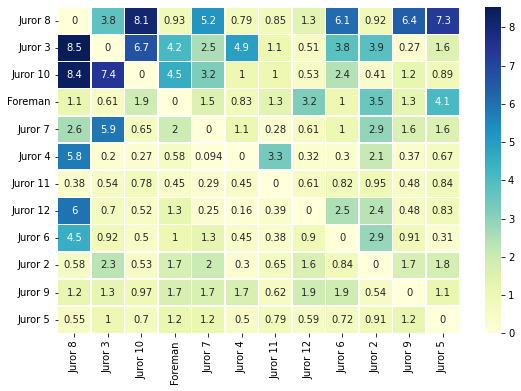

In [66]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


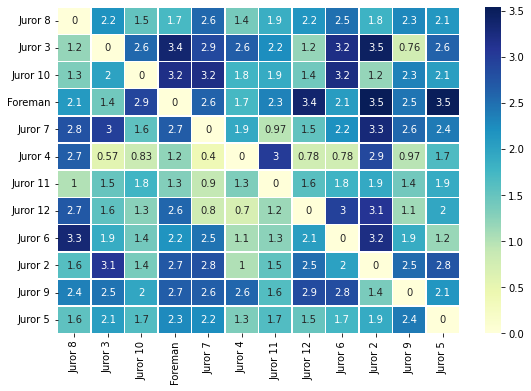

In [67]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [68]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


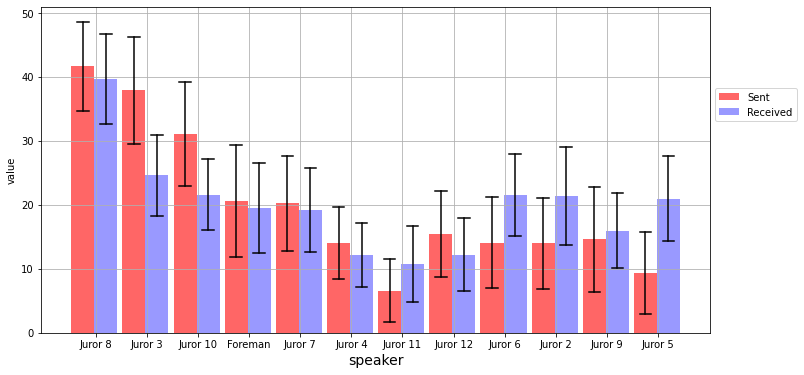

In [69]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [70]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [71]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


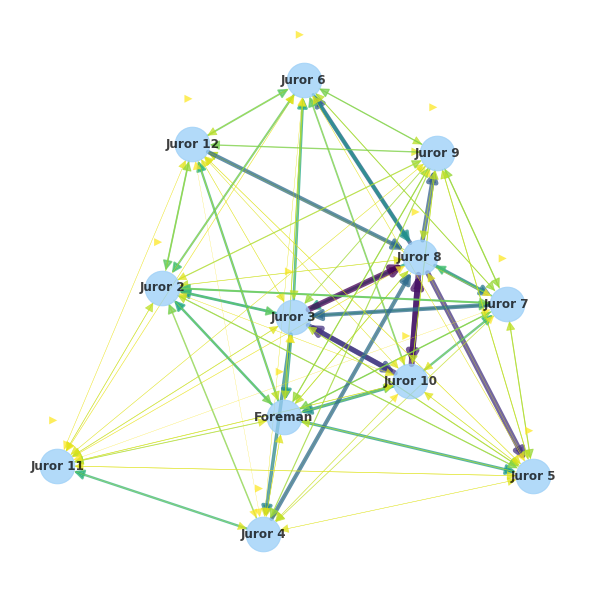

In [72]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


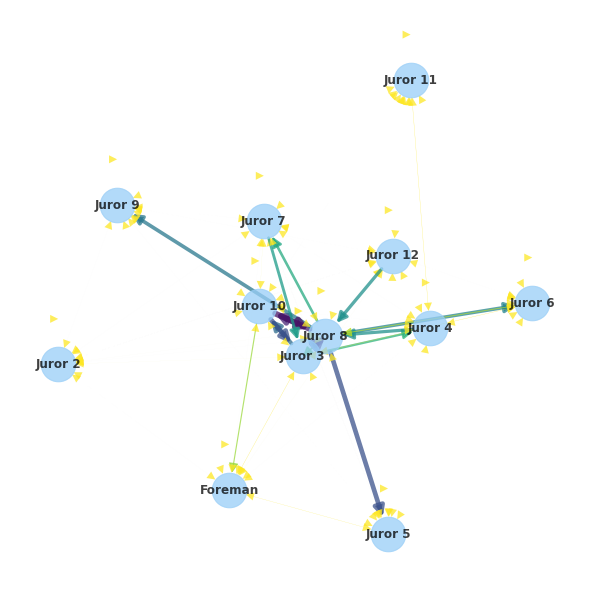

In [73]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


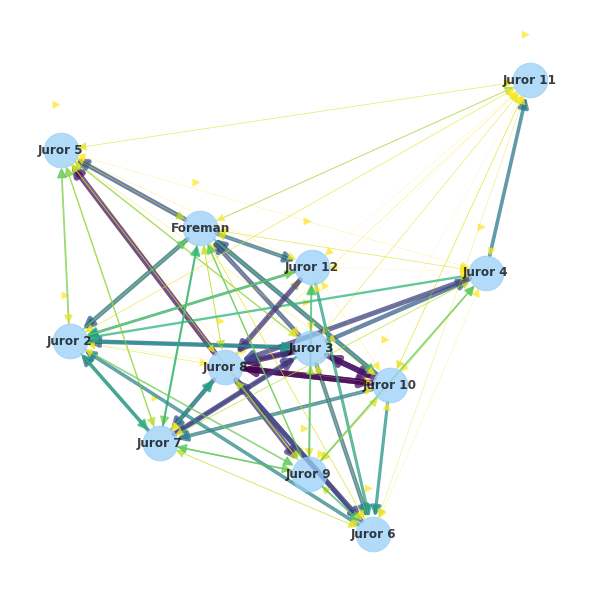

In [74]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [75]:
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

In [77]:
listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
''.join(np.random.choice(listd,4))

'slac'

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [78]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pd.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

,name,tokens,start,end
0,Roosevelt,"[bhas, sekd, dscg, sihd, dhcj, hljf, bahd, akb...",0.481378,1.861644
1,Obama,"[ecil, lcbc, bhah, fdji, ekbj, hfkc, jkcs, fsj...",2.977323,3.804124


Transform data into TalkbankXML format:

In [79]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to ./data/USpresident/USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [80]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project (__or one from ConvoKit__). Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<font color="red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<font color="red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

In this exercise I used the friends corpus from ConvoKit

In [81]:
corpus = Corpus(filename=download("friends-corpus"))

Warm-ups

In [82]:
corpus.print_summary_stats()

Number of Speakers: 700
Number of Utterances: 67373
Number of Conversations: 3107


In [85]:
corpus.random_utterance()

Utterance({'obj_type': 'utterance', 'meta': {'tokens': [['No', '-', 'no', ',', 'seriously', '-', 'seriously', ',', 'what', 'was', 'the', 'especially', 'me', 'part', 'about', '?']], 'character_entities': None, 'emotion': None, 'caption': [1024773, 1028234, 'no seriously what was the especially me part about'], 'transcript_with_note': None, 'tokens_with_note': None}, 'vectors': [], 'speaker': Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7fd9cc0b53d0>, 'id': 'Rachel Green'}), 'conversation_id': 's07_e01_c10_u001', 'reply_to': 's07_e01_c10_u034', 'timestamp': None, 'text': 'No-no, seriously-seriously, what was the especially me part about?', 'owner': <convokit.model.corpus.Corpus object at 0x7fd9cc0b53d0>, 'id': 's07_e01_c10_u035'})

In [123]:
j = 0
for i, utt in enumerate(corpus.iter_utterances()):
  if len(utt.meta['tokens']) > 5:
    print(len(utt.meta['tokens']))
    print(utt)
    j += 1
    if j == 10:
      break

11
Utterance(id: 's01_e01_c01_u056', conversation_id: s01_e01_c01_u001, reply-to: s01_e01_c01_u055, speaker: Speaker(id: Rachel Green, vectors: [], meta: {}), timestamp: None, text: "Oh God... well, it started about a half hour before the wedding. I was in the room where we were keeping all the presents, and I was looking at this gravy boat. This really gorgeous Lamauge gravy boat. When all of a sudden- Sweet 'n' Lo?- I realized that I was more turned on by this gravy boat than by Barry! And then I got really freaked out, and that's when it hit me: how much Barry looks like Mr. Potato Head. Y'know, I mean, I always knew looked familiar, but... Anyway, I just had to get out of there, and I started wondering 'Why am I doing this, and who am I doing this for?'. So anyway I just didn't know where to go, and I know that you and I have kinda drifted apart, but you're the only person I knew who lived here in the city.", vectors: [], meta: {'tokens': [['Oh', 'God', '...'], ['well', ',', 'it', 

In [96]:
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7fd9cc0b53d0>, 'id': 'Devon'})

In [98]:
corpus.get_utterance('s07_e01_c10_u001')

Utterance({'obj_type': 'utterance', 'meta': {'tokens': [], 'character_entities': None, 'emotion': None, 'caption': None, 'transcript_with_note': "[Scene: Monica and Chandler's bedroom, they are both getting undressed.]", 'tokens_with_note': [['[', 'Scene', ':', 'Monica', 'and', 'Chandler', "'s", 'bedroom', ',', 'they', 'are', 'both', 'getting', 'undressed', '.', ']']]}, 'vectors': [], 'speaker': Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7fd9cc0b53d0>, 'id': 'TRANSCRIPT_NOTE'}), 'conversation_id': 's07_e01_c10_u001', 'reply_to': None, 'timestamp': None, 'text': '', 'owner': <convokit.model.corpus.Corpus object at 0x7fd9cc0b53d0>, 'id': 's07_e01_c10_u001'})

In [103]:
corpus.get_utterance('s07_e01_c10_u035').speaker.id

'Rachel Green'

In [105]:
corpus.get_utterance('s07_e01_c10_u035').reply_to

's07_e01_c10_u034'

In [106]:
corpus.get_utterance('s07_e01_c10_u001').reply_to

Start constructing the character network

In [134]:
characters = {}
for speaker in corpus.iter_speakers():
  if speaker.id not in characters:
    characters[speaker.id] = 0

actor_network = nx.Graph()
for utt in corpus.iter_utterances():
  characters[utt.speaker.id] += 1
for character in characters:
  if characters[character] > 2000 and character != 'TRANSCRIPT_NOTE':
        actor_network.add_node(character, lines_spoken= characters[character], words=[])
actor_network.nodes.data()        

NodeDataView({'Monica Geller': {'lines_spoken': 8498, 'words': []}, 'Joey Tribbiani': {'lines_spoken': 8215, 'words': []}, 'Chandler Bing': {'lines_spoken': 8568, 'words': []}, 'Phoebe Buffay': {'lines_spoken': 7539, 'words': []}, 'Ross Geller': {'lines_spoken': 9161, 'words': []}, 'Rachel Green': {'lines_spoken': 9331, 'words': []}})

In [135]:
for utt in corpus.iter_utterances():
  if utt.speaker.id in actor_network.nodes():
    speaker1 = utt.speaker.id
    if utt.reply_to is not None:
      speaker2 = corpus.get_utterance(utt.reply_to).speaker.id
      if speaker2 in actor_network.nodes() and speaker2 != speaker1:
        if (speaker1, speaker2) not in actor_network.edges():
          actor_network.add_edge(speaker1, speaker2, weight=0)
        if (speaker1, speaker2) in actor_network.edges():
          actor_network.edges[(speaker1, speaker2)]['weight'] += 1
        # adding characters sentences
        # words = []
        # for sent in utt.meta.tokens:
        # words.extend(sent) 
        # actor_network.nodes[speaker1]['words'].append(words)
        actor_network.nodes[speaker1]['words'].append(utt.meta['tokens'])

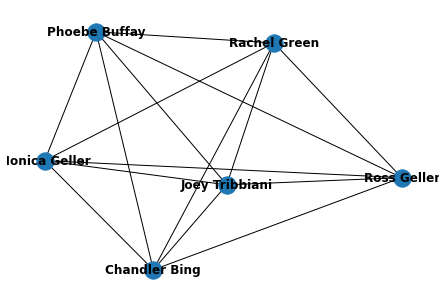

In [136]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Unsurprisingly, every one is connnected to each other. 

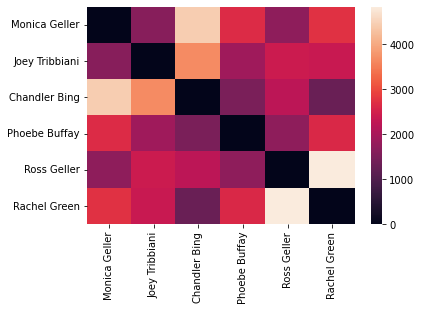

In [137]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [140]:
actor_network.edges(data=True)

EdgeDataView([('Monica Geller', 'Joey Tribbiani', {'weight': 1652}), ('Monica Geller', 'Phoebe Buffay', {'weight': 2680}), ('Monica Geller', 'Chandler Bing', {'weight': 4453}), ('Monica Geller', 'Ross Geller', {'weight': 1722}), ('Monica Geller', 'Rachel Green', {'weight': 2756}), ('Joey Tribbiani', 'Chandler Bing', {'weight': 3670}), ('Joey Tribbiani', 'Phoebe Buffay', {'weight': 1917}), ('Joey Tribbiani', 'Ross Geller', {'weight': 2430}), ('Joey Tribbiani', 'Rachel Green', {'weight': 2390}), ('Chandler Bing', 'Phoebe Buffay', {'weight': 1504}), ('Chandler Bing', 'Ross Geller', {'weight': 2233}), ('Chandler Bing', 'Rachel Green', {'weight': 1314}), ('Phoebe Buffay', 'Ross Geller', {'weight': 1727}), ('Phoebe Buffay', 'Rachel Green', {'weight': 2636}), ('Ross Geller', 'Rachel Green', {'weight': 4837})])

Seems that we can set a bar of 2000

In [141]:
smaller_actor_network = nx.Graph()
for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 2000:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])


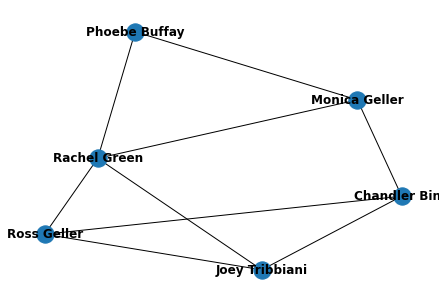

In [143]:
nx.draw(smaller_actor_network, with_labels=True, font_weight='bold')

In [145]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(smaller_actor_network))
c

[frozenset({'Monica Geller', 'Phoebe Buffay', 'Rachel Green'}),
 frozenset({'Chandler Bing', 'Joey Tribbiani', 'Ross Geller'})]

we can find that greedy_modularity_communities divided the 6 actors into 2 communities, one girl community and one boy community, which makes a lot of sense.

In [146]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentences in actor_network.nodes[character]['words']:
      for sentence in sentences:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud.normalizeTokens(character_words))

In [147]:
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

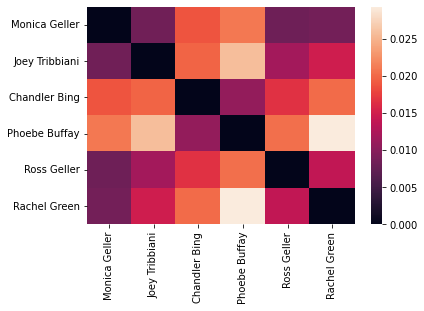

In [148]:
fig = plt.figure()
div = pd.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

Well, it seems that Joey and Monica are most similar to each other(Maybe that's why they attracted to each other at first), Phoebe is different from others as her lines were different from others especially Rachel(that's the setting of this character!). But in general, these six people are close friends, as indicated by the name of this sitcom. 

## Text Generation using GPT-2 and BERT

We can make use of the transformers we learned about last week to do text generation, where the model takes one or multiple places in a conversation. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

We will be using the built in generate function, but the example file has more detailed code which allows you to set the seed differently.

In [149]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

In [160]:
sequence = "Nothing that we like to do more than analyse data all day long and"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50) 

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Nothing that we like to do more than analyse data all day long and then try to figure out what's going on.

"We're not going to be able to do that. We're not going to be able to do that. We


Wow. A little creepy, and as we can see, far from perfect: GPT doesn't alwats work out flawlessly, but it sometimes can, and we will try and see if fine-tuning helps. We are going to tune the model on a complete dataset of Trump tweets, as they have a set of distinctive, highly identifiable qualities.

### Creating a domain-specific language model

One of the most exciting things about BERT and GPT is being able to retune them the way we want to. We will be training models to perform two tasks - one is to create a BERT with an "accent", by traning a model with english news data from the UK, from the US, and from India. We will also train a language generation model with a bunch of Trump tweets. 

We can train models specifically over a certain domain to make its language generation similar to that domain. 
[run_language modelling.py](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py), followed by [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py). I've downloaded these files and added them to this directory so we can run them through the notebook. You are encouraged to look at these files to get a rough idea of what is going on.

### Loading Data 

We want to now get our Trump tweets and our English news datasets ready. The data the scripts expect is just a text file with relevant data. We load the Trump tweets and then write them to disk as train and test files with only data. I leave the original dataframes in case you would like to use it for your own purposes.

In [151]:
dfs = []

In [153]:
for file in os.listdir("/content/drive/MyDrive/Colab Notebooks/data/data/trump_tweets"):
    dfs.append(pd.read_json("/content/drive/MyDrive/Colab Notebooks/data/data/trump_tweets/" + file))

In [154]:
df = pd.concat(dfs)

In [155]:
df.head()

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
0,Twitter for Android,682703233492619264,I would like to wish everyone A HAPPY AND HEAL...,2015-12-31 23:21:49+00:00,6776,NaN,16495,False
1,Twitter for Android,682700657304989696,"Do you believe that The State Department, on N...",2015-12-31 23:11:35+00:00,2755,NaN,6824,False
2,Twitter for iPhone,682635132038176768,THANK YOU ILLINOIS! Let's not forget to get fa...,2015-12-31 18:51:12+00:00,2468,NaN,6047,False
3,Twitter for iPhone,682605293856002048,"HAPPY BIRTHDAY to my son, @DonaldJTrumpJr! Ver...",2015-12-31 16:52:38+00:00,2080,NaN,8416,False
4,Twitter for Android,682578783912759296,I would feel sorry for @JebBush and how badly ...,2015-12-31 15:07:18+00:00,1875,NaN,5780,False


In [156]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['text'], test_size=0.2)

In [157]:
train_text.head()

2330    "@KAKJOY: @realDonaldTrump Please run for Pres...
750     Fact – Amnesty lowers wages and invites more l...
1688    "@cbauer747: @houseofwolf187 Motivate: why eve...
190     "@EyedUsa: @realDonaldTrump You are the only m...
3458    "@paranormalfact: @realDonaldTrump  If you run...
Name: text, dtype: object

In [158]:
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')

In [159]:
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

I now used the Google Colab GPUs to train the Trump tweet models. We'll be doing the same for our blog posts too.

### GloWBe dataset

We'll now load up the GloWbe (Corpus of Global Web-Based English) dataset which have different texts from different countries. We'll try and draw out texts from only the US, UK and India. We'll then save these to disk. Note that this is a Davies Corpora dataset: the full download can be done with the Dropbox link I sent in an announcement a few weeks ago. The whole download is about 3.5 GB but we only need two files, which are anout 250 MB each. The other files might be useful for your research purposes.

In [ ]:
address = "C:/Downloads/GloWbE"

In [ ]:
# these are the exact name of the files
us = "/text_us_blog_jfy.zip"
gb = "/text_gb_blog_akq.zip"

In [ ]:
us_texts = lucem_illud.loadDavies(address, corpus_style="us_blog", num_files=5000)

In [ ]:
gb_texts = lucem_illud.loadDavies(address, corpus_style="gb_blog", num_files=5000)

We now have a dictionary with document ids mapping to text. Since we don't need any information but the text, we can just save these to disk.

In [ ]:
' '.join(list(us_texts.values())[10])

In [ ]:
def dict_to_texts(texts, file_name):
    text = []
    for doc in list(texts.values()):
        text.append(' '.join(doc).replace("< h >", "").replace("< p >", ""))
    train_text, test_text = train_test_split(text, test_size=0.2)
    with open(file_name + "_train", 'w') as f:
        for item in train_text:
            f.write("%s\n" % item)
    
    with open(file_name + "_test", 'w') as f:
        for item in test_text:
            f.write("%s\n" % item)

In [ ]:
dict_to_texts(us_texts, "us_blog")

In [ ]:
dict_to_texts(gb_texts, "gb_blog")

We now have the training and testing files for both US and GB blogs in English. 

(WARNING - SHIFT TO GOOGLE COLAB OR GPU ENABLED MACHINE)


### Running Scripts

We use the scripts to do language modelling and text generation. The following cells run the code as if you would have run it in a terminal.

#### Trump GPT-2

In [ ]:
# You might have issues with the memory of your GPU in the following code.
# The default Google Colab GPU should work with batch size of 2,
# but if you get a "CUDA out of memory" error, you can reduce it to 1.

# !python run_language_modeling.py --per_gpu_train_batch_size=1 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump
!python run_language_modeling.py --per_gpu_train_batch_size=2 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump
# !python run_language_modeling.py --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump

# If the GPU memory error still occurs even with a batch size of 1,
# you can need to run the code on RCC Midway
# (See https://github.com/UChicago-Computational-Content-Analysis/Frequently-Asked-Questions/issues/18)

#### RoBERTa US

In [ ]:
!python run_language_modeling.py --output_dir=output_roberta_us --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=us_blog_train --do_eval --eval_data_file=us_blog_test --mlm

#### RoBERTa UK

In [ ]:
!python run_language_modeling.py --output_dir=output_roberta_gb --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=gb_blog_train --do_eval --eval_data_file=gb_blog_test --mlm

(If you left to use a GPU machine, COME BACK TO THIS NOTEBOOK to load and work with your trained model.)

### Loading and using models

Let us now load the four models we have and see how we can use them.

And now - let us see what our Trump Tweet Bot looks like!
You can generate text via command line using the command below. You can also load a model once it is saved - I trained my model using Google Colab, downloaded the model, and am loading it again via the command below. Note that you have to download all the files in your folder of the fine-tuned model to use the model.

In [ ]:
# !python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_trump

In [ ]:
tokenizer_trump = AutoTokenizer.from_pretrained("output_gpt_trump")
# If this line does not work, try tokenizer_trump = AutoTokenizer.from_pretrained("gpt2")

model_trump = AutoModelWithLMHead.from_pretrained("output_gpt_trump")

In [ ]:
sequence = "Obama is going to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Wow - our Trump bot is nasty, so we know our model trained well. What happens if we try the same sentence for our non-fine tuned model?

In [ ]:
sequence = "Obama is going to"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Quite the contrast.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

In [187]:
citations = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/week8-text-generation/MEDIA_CITATIONS.csv')
citations = citations.loc[:, ['TITLE','DATE', 'MEDIA']]
citations

,TITLE,DATE,MEDIA
0,"Timuel Black, Chicago historian and civil righ...","Oct 13, 2021",abc7chicago.com
1,Chicago civil rights icon Timuel Black dies at...,"Oct 13, 2021",wgntv.com
2,"Timuel Black, historian, civil rights activist...","Oct 13, 2021",chicago.suntimes.com
3,MacArthur Foundation fellowship recipients inc...,"Sep 28, 2021",chicago.suntimes.com
4,MacArthur fellowship for this Academy Museum f...,"Sep 28, 2021",www.latimes.com
...,...,...,...
8513,"Open house to feature free lectures, tours, pe...","Oct 28, 1993",chronicle.uchicago.edu
8514,President Sonnenschein,"Oct 14, 1993",chronicle.uchicago.edu
8515,Bike ride with President Sonnenschein,"Oct 14, 1993",chronicle.uchicago.edu
8516,Sonnenschein inauguration Oct. 20 in Rockefell...,"Oct 14, 1993",chronicle.uchicago.edu


In [188]:
train_idx, test_idx = train_test_split(citations.index, test_size=0.3, random_state=42)

In [189]:
train_citations = citations.iloc[train_idx, :]

In [190]:
test_citations = citations.iloc[test_idx, :]

In [192]:
train_citations['TITLE'].to_frame().to_csv(r'/content/drive/MyDrive/Colab Notebooks/week8-text-generation/train_data_citations', header=None, index=None, sep=' ', mode='a')
test_citations['TITLE'].to_frame().to_csv(r'/content/drive/MyDrive/Colab Notebooks/week8-text-generation/test_data_citations', header=None, index=None, sep=' ', mode='a')

In [177]:
!cd /content/drive/MyDrive/Colab\ Notebooks/week8-text-generation

In [200]:
!python /content/drive/MyDrive/Colab\ Notebooks/week8-text-generation/run_language_modeling.py --per_gpu_train_batch_size=2 --output_dir=/content/drive/MyDrive/Colab\ Notebooks/week8-text-generation/output_gpt --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_data_citations --do_eval --eval_data_file=test_data_citations

03/09/2022 02:21:42 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/09/2022 02:21:51 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, block_size=1024, cache_dir='', config_name='', device=device(type='cuda'), do_eval=True, do_lower_case=False, do_train=True, eval_all_checkpoints=False, eval_data_file='test_data_citations', evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=1, learning_rate=5e-05, local_rank=-1, logging_steps=50, max_grad_norm=1.0, max_steps=-1, mlm=False, mlm_probability=0.15, model_name_or_path='gpt2', model_type='gpt2', n_gpu=1, no_cuda=False, num_train_epochs=1.0, num_warmup_steps=0, output_dir='/content/drive/MyDrive/Colab Notebooks/week8-text-generation/output_gpt', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=1, per_gpu_train_batch_size=2, save_steps=50, save_total_limit=None, seed=42,

In [230]:
tokenizer_gpt = AutoTokenizer.from_pretrained("output_gpt")
model_gpt = AutoModelWithLMHead.from_pretrained("output_gpt")

In [231]:
sequence = "Law School Professor Barack Obama"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Law School Professor Barack Obama, who was a member of the National Academy of Sciences, said the study was "a step in the right direction."

"The study shows that the brain is a very important part of our lives," Obama said.


hahaha the whole sentence would be very reasonable if Obama was once a professor in Life/Neural Science 😄

In [204]:
sequence = "President Obama said"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

President Obama said he would not be surprised if the U.S. Supreme Court ruled against the Obama administration's efforts to block the Affordable Care Act.

"I think it's a good thing that the Supreme Court has decided to hear the case


😄 The model found the correlation between Obama and the Affordable Care Act. But the model made a mistake! The Affordable Care Act was signed by President Obama. 

The corpus I used is titles of all historicall news Univerisity of Chicago ever cited. We can find from the generated texts that they're very formal, and closely related to real world events. But the dataset is small, we only have around 8500 records. More traininng records may help the model achieve better performance. 

Compare with non-fine tuned models

In [205]:
tokenizer_gpt_non = AutoTokenizer.from_pretrained("gpt2")
model_gpt_non = AutoModelWithLMHead.from_pretrained("gpt2")

In [206]:
sequence = "Law School Professor Barack Obama"

input = tokenizer_gpt_non.encode(sequence, return_tensors="pt")
generated = model_gpt_non.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt_non.decode(generated.tolist()[0])
print(resulting_string)

Law School Professor Barack Obama, who is a former U.S. ambassador to the United Nations, said that the U.S. has a "very strong relationship" with the Islamic State.

"We have a very strong relationship with the


In [207]:
sequence = "President Obama said"

input = tokenizer_gpt_non.encode(sequence, return_tensors="pt")
generated = model_gpt_non.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt_non.decode(generated.tolist()[0])
print(resulting_string)

President Obama said he was "deeply concerned" about the "unprecedented" number of people who have been killed in the U.S. military's drone strikes.

"I'm deeply concerned about the number of people who have been


Well, it's unlikely something what a president of U.S. would say. 

Contextual models can also help us visualize how words in a sentence or different or similar to each other. We will try to construct sentences where words might mean different things in different countries - in the US, people might eat chips with salsa, but in the UK, chips are what Americans call french fries, and might eat it fried fish instead. 

In [209]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [ ]:
roberta_us_model_embedding = RobertaModel.from_pretrained('roberta_us')

In [ ]:
roberta_us_tokenizer = RobertaTokenizer.from_pretrained('roberta_us')

In [211]:
text = "Do you have your chips with fish or with salsa?" 

In [ ]:
text1 = "He went out in just his undershirt and pants." #pants are underwear in Britain; maybe closer to an undershirt
text2 = "His braces completed the outfit." #braces are suspenders (in Britain); maybe closer to an outfit
text3 = "Does your pencil have a rubber on it?" #rubber is an eraser in Britain); maybe closer to a pencil
text4 = "Was the bog closer to the forest or the house?" #bog is a toilen in Britain); maybe closer to a house
text5 = "Are you taking the trolley or the train to the grocery market" #trolley is a food carriage; possibly closer to a market

In [212]:
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

In [ ]:
visualise_diffs(text, roberta_us_model_embedding, roberta_us_tokenizer)

In [ ]:
roberta_gb_model_embedding = RobertaModel.from_pretrained('roberta_gb')
roberta_gb_tokenizer = RobertaTokenizer.from_pretrained('roberta_gb')

In [ ]:
visualise_diffs(text, roberta_gb_model_embedding, roberta_gb_tokenizer)

## <font color="red">*Exercise 4*</font>

<font color="red">What's a research question relevant to your final project that would benefit from a generative or conversational model like GPT-2 or GPT-3? What task would you have it perform, and how would you evaluate the ouput?
    
<font color="red">_Stretch:_ Do it!

My final project has to do with movies and movie commments. On any movie review website, we can find that the number of movie comments of different movies varies greatly. It's undeniable that the quality of the movie itself is a very important reason, but the introduciton to the movie also matters. If an introduction is very attractive, it's possible that more people would choose to watch the movie and leave comments.So a research question could be framed like this: What kinds of movie introductions would be more attractive? 

A research question like this could greatly benefit from using models like GPT2 or GPT3. To test this effect, we need to generate many verions of introductions for many movies. Then we may recruite MTurkers to tell how bad do they want to watch those movies given different movie introductions. However, writing artful movie introducitons can be a very creative and difficult job. It's not a good idea to train MTurkers to do such a job. If researchers do this job on their own? Two drawbacks. First it could be really torching. Second, the well of your ideas could be drained. Given one movie, how many versions of introductions could you write down? 1? A piece of cake. 10? Challeging. 100? Crazy! But with a GPT2 or GPT3, we just need to feed the model with movie transcripts, and give it some prompts. So the model could generate thousands of different introductions effortlessly. All the researchers need to do is to filter out those introductions that doesn't make sense. This is much easier than creating some introductions on thier own.

In this exercise I will use GPT2 and movie dialogs from Convokit to see if a fine-tuned GPT2 model could generate some attractive introductions relevant to the movies. This is just a rudimentary attempt, it's for sure that we need to pay a lot more efforts to make GPT2 or GPT3 suitable for doing such a task. 

In [213]:
corpus = Corpus(filename=download("movie-corpus"))

In [216]:
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {'character_name': 'SCUD', 'movie_idx': 'm271', 'movie_name': 'blade ii', 'gender': '?', 'credit_pos': '?'}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x7fd7152b6f50>, 'id': 'u4078'})

In [215]:
corpus.random_utterance()

Utterance({'obj_type': 'utterance', 'meta': {'movie_id': 'm317', 'parsed': [{'rt': 0, 'toks': [{'tok': 'No', 'tag': 'UH', 'dep': 'ROOT', 'dn': [1]}, {'tok': '.', 'tag': '.', 'dep': 'punct', 'up': 0, 'dn': []}]}, {'rt': 2, 'toks': [{'tok': 'They', 'tag': 'PRP', 'dep': 'nsubj', 'up': 2, 'dn': []}, {'tok': 'just', 'tag': 'RB', 'dep': 'advmod', 'up': 2, 'dn': []}, {'tok': 'try', 'tag': 'VBP', 'dep': 'ROOT', 'dn': [0, 1, 4, 8]}, {'tok': 'to', 'tag': 'TO', 'dep': 'aux', 'up': 4, 'dn': []}, {'tok': 'hold', 'tag': 'VB', 'dep': 'xcomp', 'up': 2, 'dn': [3, 5, 6]}, {'tok': 'you', 'tag': 'PRP', 'dep': 'dobj', 'up': 4, 'dn': []}, {'tok': 'for', 'tag': 'IN', 'dep': 'prep', 'up': 4, 'dn': [7]}, {'tok': 'ransom', 'tag': 'NN', 'dep': 'pobj', 'up': 6, 'dn': []}, {'tok': '.', 'tag': '.', 'dep': 'punct', 'up': 2, 'dn': []}]}, {'rt': 0, 'toks': [{'tok': 'Fuck', 'tag': 'RB', 'dep': 'ROOT', 'dn': [1, 2, 3, 4]}, {'tok': 'you', 'tag': 'PRP', 'dep': 'dobj', 'up': 0, 'dn': []}, {'tok': ',', 'tag': ',', 'dep': 'p

In [221]:
corpus.random_utterance().meta['movie_id']

'm451'

In [223]:
# let's try the movie m271: Blade ii
lines = []
for utt in corpus.iter_utterances():
  if utt.meta['movie_id'] == 'm217':
    lines.append(utt.text)
len(lines)

817

In [226]:
lines = pd.DataFrame(lines)

# our puropse is do abstraction. So we want overfit. Here we don't do train test split.

In [228]:
lines.to_csv(r'one_movie_dialogs', header=None, index=None, sep=' ', mode='a')

In [229]:
!python /content/drive/MyDrive/Colab\ Notebooks/week8-text-generation/run_language_modeling.py --per_gpu_train_batch_size=2 --output_dir=/content/drive/MyDrive/Colab\ Notebooks/week8-text-generation/output_movie_gpt --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=one_movie_dialogs

03/09/2022 05:37:49 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/09/2022 05:37:58 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, block_size=1024, cache_dir='', config_name='', device=device(type='cuda'), do_eval=False, do_lower_case=False, do_train=True, eval_all_checkpoints=False, eval_data_file=None, evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=1, learning_rate=5e-05, local_rank=-1, logging_steps=50, max_grad_norm=1.0, max_steps=-1, mlm=False, mlm_probability=0.15, model_name_or_path='gpt2', model_type='gpt2', n_gpu=1, no_cuda=False, num_train_epochs=1.0, num_warmup_steps=0, output_dir='/content/drive/MyDrive/Colab Notebooks/week8-text-generation/output_movie_gpt', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=1, per_gpu_train_batch_size=2, save_steps=50, save_total_limit=None, seed=42, server_ip

In [233]:
dir = '/content/drive/MyDrive/Colab Notebooks/week8-text-generation/output_movie_gpt'
tokenizer_gpt = AutoTokenizer.from_pretrained(dir)
model_gpt = AutoModelWithLMHead.from_pretrained(dir)

# here we use the two sentences of introduction of this movie from IMDb as prompts.
sequence = "A rare mutation has occurred within the vampire community. The Reaper. A vampire so consumed with an insatiable bloodlust that they prey on vampires as well as humans, transforming victims who are unlucky enough to survive into Reapers themselves."

input = tokenizer_gpt_non.encode(sequence, return_tensors="pt")
generated = model_gpt_non.generate(input, max_length=200, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt_non.decode(generated.tolist()[0])
print(resulting_string)

A rare mutation has occurred within the vampire community. The Reaper. A vampire so consumed with an insatiable bloodlust that they prey on vampires as well as humans, transforming victims who are unlucky enough to survive into Reapers themselves.

The Reaper is a powerful and deadly creature. It is the only vampire that can be killed by a single blow. It is also the only vampire that can be killed by a single blow.

The Reaper is a powerful and deadly creature. It is the only vampire that can be killed by a single blow. It is also the only vampire that can be killed by a single blow. The Reaper is a powerful and deadly creature. It is the only vampire that can be killed by a single blow. The Reaper is a powerful and deadly creature. It is the only vampire that can be killed by a single blow. The Reaper is a powerful and deadly creature. It is the only vampire that can be killed by a single blow. The Reaper is a


😢It performs really bad. It seems that we need a more powerful model like GPT3. And maybe I'm wrong. We still need a lot of data to fine tune the model, and then give the movel a prompt to require it to generate a creative abstraction of the movie. 

# Optional: AI Dungeon
A fun way to explore the power of conversation and text generation is [AI Dungeon](https://play.aidungeon.io/main/newGame). If you select _Quick Start_, you can start a text adventure similar to the popular role-playing game Dungeons and Dragons, or the "choose your own adventure" books some of us boomers read as kids. AI Dungeon used to use GPT-2 but now uses GPT-3 to generate text in response to your actions. For example, you may begin with the prompt:

```
You are Jimmy, a wizard living in the kingdom of Larion. You have a staff and a spellbook. You finish your long journey and finally arrive at the ruin you've been looking for. You have come here searching for a mystical spellbook of great power called the book of essence. You look around and see a beautiful woman with raven hair and dark, sparkling eyes. She approaches you and asks you what you seek.

You are now before the one known as Raven.
```

You can respond with any text. I type, `I ask Raven, "What is the meaning of life?"`, to which AI Dungeon says:

```
Raven ponders the question for a moment, and then she answers. Raven says, "It is the pursuit of happiness." What is the pursuit of happiness?
```

I type, `I respond, "Happiness to me would be unearthing the treasures of the Kilarean Empire."`:

```
Raven looks at me and says, "Come with me and live out your one true life."

You go with Raven through many passages and up and down elevators.
```

Raven might be helping me unearth the treasures! Not bad!

There are a lot of tools like AI Dungeon being developed now with state-of-the-art language models. Now that you have some understanding of deep language models, you can better appreciate them—and perhaps design some of your own!